# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up graphlab create

In [75]:
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import graphlab as gl
print gl.version
gl.canvas.set_target('ipynb')
from sklearn import metrics

1.8.1


# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [65]:
sales = gl.SFrame('data/kc_house_data.gl/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [66]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [67]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [69]:
model_all = gl.linear_regression.create(sales, \
                                target='price', features=all_features, \
                                              validation_set=None, \
                                            l2_penalty=0., l1_penalty=1e10)

PROGRESS: Linear regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 21613
PROGRESS: Number of features          : 17
PROGRESS: Number of unpacked features : 17
PROGRESS: Number of coefficients    : 18
PROGRESS: Starting Accelerated Gradient (FISTA)
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: Tuning step size. First iteration could take longer than subsequent iterations.
PROGRESS: | 1         | 2        | 0.000002  | 0.959779     | 6962915.603493     | 426631.749026 |
PROGRESS: | 2         | 3        | 0.000002  | 1.027698     | 6843144.200219     | 392488.929838 |
PROGRESS: | 3         | 4      

Find what features had non-zero weight.

In [70]:
print (model_all \
           .get("coefficients") \
           .sort('value', ascending = False) \
           .print_rows(num_rows = len(all_features) + 1) \
      ) 
print (model_all \
           .get("coefficients") \
           .sort('value', ascending = False) \
           .filter_by(0.0, 'value')
           .shape \
      ) 

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None |  274873.05595 |  None  |
|    bathrooms     |  None | 8468.53108691 |  None  |
|      grade       |  None | 842.068034898 |  None  |
| sqft_living_sqrt |  None | 350.060553386 |  None  |
|   sqft_living    |  None | 24.4207209824 |  None  |
|    sqft_above    |  None | 20.0247224171 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|     bedrooms     |  None |      0.0      |  None  |
|  sqft_basement   |  None |

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [71]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [122]:
def fitMdlL1Penalty(l1PenaltyLst):
    mdlDF = pd.DataFrame({'l1_penalty': l1PenaltyLst})
    mdlDF = mdlDF.set_index(pd.Series( \
                ['%.4e' % (l1p) for l1p in mdlDF['l1_penalty']]))
    mdlDF['mdl'] = gl.linear_regression.create(training, \
                                target = 'price', features=all_features, \
                                                        verbose = False)
#     mdlDF['coeff.nnz'] = -1
#     mdlDF['RSS.vld'] = -1

    for l1pIx in xrange(mdlDF.shape[0]):
        l1pIxRowLabel = mdlDF.index[l1pIx]
        # print l1pIxRowLabel
        print 'Fitting model with l1_penalty: %s:' % (l1pIxRowLabel)
        mdl = gl.linear_regression.create(training, \
                                target='price', features=all_features, \
                                validation_set = None, verbose = False, \
                                            l2_penalty = 0., \
                        l1_penalty = mdlDF.ix[l1pIxRowLabel, 'l1_penalty'])
        mdlDF.ix[l1pIxRowLabel, 'mdl'] = mdl
        mdlDF.ix[l1pIxRowLabel, 'coeff.nnz'] = (mdl \
           .get("coefficients")['value'] \
           .nnz()
        )        
        mdlDF.ix[l1pIxRowLabel, 'RSS.vld'] = \
            ((mdl.predict(validation) - validation['price']) ** 2).sum()

    print mdlDF
    pltResults(l1PenaltyLst)

    return(mdlDF)

Fitting model with l1_penalty: 1.0000e+01:
Fitting model with l1_penalty: 3.1623e+01:
Fitting model with l1_penalty: 1.0000e+02:
Fitting model with l1_penalty: 3.1623e+02:
Fitting model with l1_penalty: 1.0000e+03:
Fitting model with l1_penalty: 3.1623e+03:
Fitting model with l1_penalty: 1.0000e+04:
Fitting model with l1_penalty: 3.1623e+04:
Fitting model with l1_penalty: 1.0000e+05:
Fitting model with l1_penalty: 3.1623e+05:
Fitting model with l1_penalty: 1.0000e+06:
Fitting model with l1_penalty: 3.1623e+06:
Fitting model with l1_penalty: 1.0000e+07:
                 l1_penalty  \
1.0000e+01        10.000000   
3.1623e+01        31.622777   
1.0000e+02       100.000000   
3.1623e+02       316.227766   
1.0000e+03      1000.000000   
3.1623e+03      3162.277660   
1.0000e+04     10000.000000   
3.1623e+04     31622.776602   
1.0000e+05    100000.000000   
3.1623e+05    316227.766017   
1.0000e+06   1000000.000000   
3.1623e+06   3162277.660168   
1.0000e+07  10000000.000000   

      

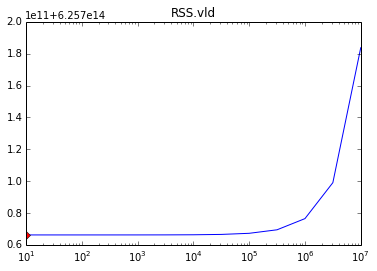

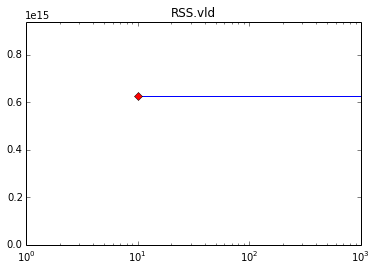

In [87]:
l1_penalty_srch1 = fitMdlL1Penalty(np.logspace(1, 7, num = 13))

*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?
2. What is the RSS on TEST data of the model with the best `l1_penalty`?

In [88]:
print l1_penalty_srch1.ix[l1_penalty_srch1['RSS.vld'].argmin()]

l1_penalty                                                   10
mdl           Class                         : LinearRegressi...
coeff.nnz                                                    18
RSS.vld                                             6.25766e+14
Name: 1.0000e+01, dtype: object


In [89]:
print 'RSS.tst: %0.4e' % \
    ((l1_penalty_srch1['mdl'][l1_penalty_srch1['RSS.vld'].argmin()].predict(testing) - \
      testing['price']) ** 2).sum()

RSS.tst: 1.5698e+14


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [97]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [91]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

Fitting model with l1_penalty: 1.0000e+08:
Fitting model with l1_penalty: 1.2743e+08:
Fitting model with l1_penalty: 1.6238e+08:
Fitting model with l1_penalty: 2.0691e+08:
Fitting model with l1_penalty: 2.6367e+08:
Fitting model with l1_penalty: 3.3598e+08:
Fitting model with l1_penalty: 4.2813e+08:
Fitting model with l1_penalty: 5.4556e+08:
Fitting model with l1_penalty: 6.9519e+08:
Fitting model with l1_penalty: 8.8587e+08:
Fitting model with l1_penalty: 1.1288e+09:
Fitting model with l1_penalty: 1.4384e+09:
Fitting model with l1_penalty: 1.8330e+09:
Fitting model with l1_penalty: 2.3357e+09:
Fitting model with l1_penalty: 2.9764e+09:
Fitting model with l1_penalty: 3.7927e+09:
Fitting model with l1_penalty: 4.8329e+09:
Fitting model with l1_penalty: 6.1585e+09:
Fitting model with l1_penalty: 7.8476e+09:
Fitting model with l1_penalty: 1.0000e+10:
              l1_penalty                                                mdl  \
1.0000e+08  1.000000e+08  Class                         : Lin

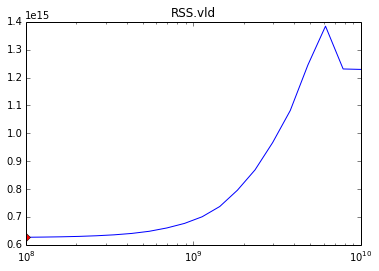

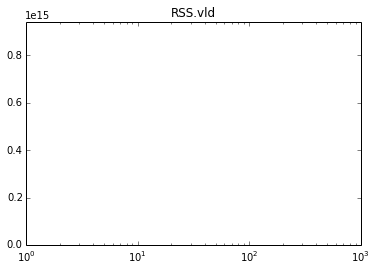

In [92]:
l1_penalty_srch2 = fitMdlL1Penalty(l1_penalty_values)

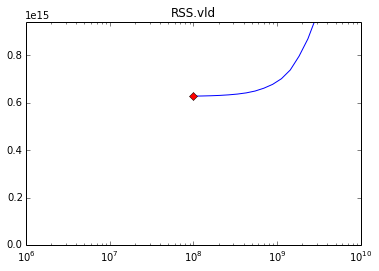

In [93]:
mdlDF = l1_penalty_srch2
plt.figure()
plt.plot(mdlDF['l1_penalty'], mdlDF['RSS.vld'],'-', \
             mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()], \
                 mdlDF['RSS.vld'].min(),'rD')
plt.title("RSS.vld")
plt.xscale('log')
axes = plt.gca()
axes.set_xlim([mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
               mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2])
axes.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])
plt.show()
    

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [100]:
l1_penalty_min = l1_penalty_srch2[ \
        l1_penalty_srch2['coeff.nnz'] > max_nonzeros]['l1_penalty'].max()
print 'l1_penalty_min: %.04e' % (l1_penalty_min)
print l1_penalty_srch2[l1_penalty_srch2['l1_penalty'] == l1_penalty_min]

l1_penalty_max = l1_penalty_srch2[ \
        l1_penalty_srch2['coeff.nnz'] < max_nonzeros]['l1_penalty'].min()
print 'l1_penalty_max: %.04e' % (l1_penalty_max)
print l1_penalty_srch2[l1_penalty_srch2['l1_penalty'] == l1_penalty_max]

l1_penalty_min: 2.9764e+09
              l1_penalty                                                mdl  \
2.9764e+09  2.976351e+09  Class                         : LinearRegressi...   

            coeff.nnz       RSS.vld  
2.9764e+09         10  9.669257e+14  
l1_penalty_max: 3.7927e+09
              l1_penalty                                                mdl  \
3.7927e+09  3.792690e+09  Class                         : LinearRegressi...   

            coeff.nnz       RSS.vld  
3.7927e+09          6  1.081868e+15  


***QUIZ QUESTIONS***

What values did you find for `l1_penalty_min` and`l1_penalty_max`? 

In [136]:
print 'l1_penalty_min:%d; l1_penalty_max:%d' % \
    (l1_penalty_min, l1_penalty_max)

l1_penalty_min:2976351441; l1_penalty_max:3792690190


## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [101]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzero`.

Fitting model with l1_penalty: 2.9764e+09:
Fitting model with l1_penalty: 3.0193e+09:
Fitting model with l1_penalty: 3.0623e+09:
Fitting model with l1_penalty: 3.1052e+09:
Fitting model with l1_penalty: 3.1482e+09:
Fitting model with l1_penalty: 3.1912e+09:
Fitting model with l1_penalty: 3.2341e+09:
Fitting model with l1_penalty: 3.2771e+09:
Fitting model with l1_penalty: 3.3201e+09:
Fitting model with l1_penalty: 3.3630e+09:
Fitting model with l1_penalty: 3.4060e+09:
Fitting model with l1_penalty: 3.4490e+09:
Fitting model with l1_penalty: 3.4919e+09:
Fitting model with l1_penalty: 3.5349e+09:
Fitting model with l1_penalty: 3.5779e+09:
Fitting model with l1_penalty: 3.6208e+09:
Fitting model with l1_penalty: 3.6638e+09:
Fitting model with l1_penalty: 3.7068e+09:
Fitting model with l1_penalty: 3.7497e+09:
Fitting model with l1_penalty: 3.7927e+09:
              l1_penalty                                                mdl  \
2.9764e+09  2.976351e+09  Class                         : Lin

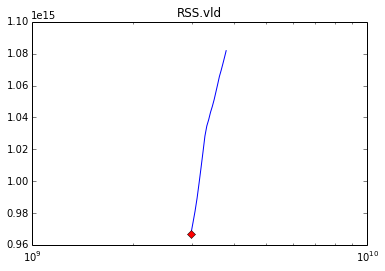

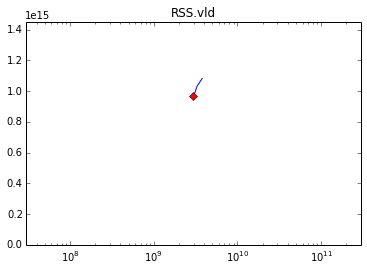

In [102]:
l1_penalty_srch3 = fitMdlL1Penalty(l1_penalty_values)

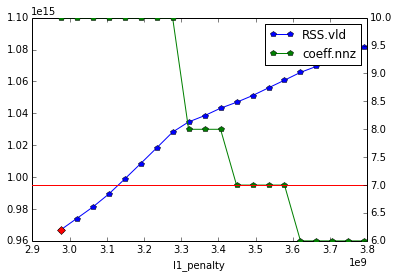

In [121]:
def pltResults(mdlDF):
    plt.figure()
    lgndFeats = []
    
    ax = plt.gca()
    lgndFeats.append(ax.plot(mdlDF['l1_penalty'], mdlDF['RSS.vld'], \
                             'bp-', label = "RSS.vld"))
    ax.plot(mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()], \
                     mdlDF['RSS.vld'].min(),'rD')    
    ax.set_xlabel('l1_penalty')        
    #ax.set_xlim([ \
    #        mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
    #        mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2] \
    #             )
    #ax.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])
    
    ax2 = ax.twinx()
    lgndFeats.append(ax2.plot(mdlDF['l1_penalty'], mdlDF['coeff.nnz'], \
                              'gp-', label = "coeff.nnz"))
    ax2.axhline(y = max_nonzeros, color = 'r')
    
    lgndFeatsSum = lgndFeats[0] + lgndFeats[1]
    ax.legend(lgndFeatsSum, \
              [feat.get_label() for feat in lgndFeatsSum]
             )
    #plt.title("RSS.vld")
    #plt.xscale('log')    
    plt.show()
    
pltResults(l1_penalty_srch3)


In [127]:
l1_penalty_srch3_select = \
    l1_penalty_srch3[l1_penalty_srch3['coeff.nnz'] == max_nonzeros]
print l1_penalty_srch3_select
l1_penalty_srch3_select = \
    l1_penalty_srch3_select[l1_penalty_srch3_select['RSS.vld'] == \
                            l1_penalty_srch3_select['RSS.vld'].min()]
print l1_penalty_srch3_select

              l1_penalty                                                mdl  \
3.4490e+09  3.448969e+09  Class                         : LinearRegressi...   
3.4919e+09  3.491934e+09  Class                         : LinearRegressi...   
3.5349e+09  3.534899e+09  Class                         : LinearRegressi...   
3.5779e+09  3.577864e+09  Class                         : LinearRegressi...   

            coeff.nnz       RSS.vld  
3.4490e+09          7  1.046937e+15  
3.4919e+09          7  1.051148e+15  
3.5349e+09          7  1.055993e+15  
3.5779e+09          7  1.060800e+15  
              l1_penalty                                                mdl  \
3.4490e+09  3.448969e+09  Class                         : LinearRegressi...   

            coeff.nnz       RSS.vld  
3.4490e+09          7  1.046937e+15  


***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [137]:
print '%d' % (l1_penalty_srch3_select['l1_penalty'])

3448968612


In [133]:
#print type(l1_penalty_srch3_select['mdl'][0])
selMdlCoeffs = l1_penalty_srch3_select['mdl'][0].get("coefficients")
selMdlCoeffs.print_rows(num_rows = selMdlCoeffs.num_rows())

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None | 222253.192544 |  None  |
|     bedrooms     |  None | 661.722717782 |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 15873.9572593 |  None  |
|   sqft_living    |  None | 32.4102214513 |  None  |
| sqft_living_sqrt |  None | 690.114773313 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 2899.42026975 |  None  |
|    sqft_above    |  None | 30.0115753022 |  None  |
|  sqft_basement   |  None |

In [135]:
print 'min:%d; max:%d' % (2.976351e+09, 3.792690e+09)

min:2976351000; max:3792690000
